# Recommender System

A streamlined recommender system framework with NLP capabilities for easy experimentation.

## Installation

1. Install core dependencies:

```bash
pip install polars catboost optuna scikit-learn pandas numpy
```

2. Install NLP dependencies:

```bash
pip install sentence-transformers
```

## Project Structure

The  framework consists of these key components:

- `data_loader.py` - Handles data loading and time-based splitting
- `experiment.py` - Manages the experiment lifecycle
- `hyperparameter_tuner.py` - Provides optional parameter tuning
- `text_processor.py` - Processes text features using pretrained models
- `feature_factory.py` - Generates features, handles dependencies, keeps track of categorical columns
- `model_factory.py` - Model factory



## Basic Usage

```python
from lavka_recsys import Config, Experiment, register_text_embedding_features

# Allows use of NLP features ("product_embeddings", "category_embeddings", etc) 
register_text_embedding_features()

# Create configuration
config = Config({
    "experiment_name": "simple_recommender",
    "model": {
        "type": "catboost",
        "config": {
            "catboost": {
                "iterations": 500,
                "learning_rate": 0.1,
                "depth": 6
            }
        }
    },
    "features": [
        "count_purchase_user_product",
        "ctr_product",
        "user_stats", 
        "product_stats",
        "store_stats",
        "product_embeddings",
        "category_embeddings"
    ],
    "target": "CartUpdate_Purchase_vs_View",
    "data": {
        "train_path": "data/train.parquet",
        "test_path": "data/test.parquet"
    },
    "text_processing": {
        "model_type": "sentence-transformers",
        "model_name": "all-MiniLM-L6-v2",
        "embedding_dimensions": 20
    }
})

# Create and run experiment
experiment = SimpleExperiment("my_experiment", config)
results = experiment.run()
print(f"Metrics: {results['metrics']}")

# Generate predictions
submission = experiment.predict()
```

## Text Feature Options

The system supports multiple pretrained NLP models:

1. **Sentence Transformers** (recommended):
   - Modern, transformer-based embeddings
   - Configuration: `"model_type": "sentence-transformers"`
   - Good models: `"all-MiniLM-L6-v2"` (small), `"all-mpnet-base-v2"` (larger but better)

2. **Word2Vec** (optional):
   - Classic word embeddings
   - Configuration: `"model_type": "word2vec"`
   - Good models: `"glove-wiki-gigaword-100"`, `"word2vec-google-news-300"`


## Hyperparameter Tuning

To run with hyperparameter tuning:

```python
results = experiment.run_with_tuning()
best_params = results['best_params']
submission = experiment.predict(best_params)
```

## Customization

For custom feature engineering, simply add your feature generators to the `feature_factory.py` file as you've been doing.

## Memory Requirements

- **Base System**: ~2GB RAM
- **With Sentence Transformers**: ~3GB RAM (depends on model size)
- **With Word2Vec**: ~2.5GB RAM

## Troubleshooting

- If you encounter memory issues, try a smaller model or reduce embedding dimensions
- For faster debugging, set `"data.sample_fraction": 0.1` in your configuration

In [1]:
from datetime import datetime

In [2]:
# %load_ext autoreload
# %autoreload 2
from lavka_recsys import Config, Experiment, setup_logging, Visualizer, FeatureFactory, FeatureSelector, DataLoader

In [3]:
config_dict = {
    "experiment_name": "simple_recommender",
    "model": {
        "type": "catboost",
        "config": {
            "catboost": {
                "iterations": 1000,
                "learning_rate": 0.1,
                "depth": 6,
                "verbose": 100
            }
        }
    },
    "features": [
        "count_purchase_user_product",
        "count_purchase_user_store",
        "ctr_product", 
        "user_stats",
        "product_stats",
        "store_stats",
        "city_stats",
        "recency_user_product",
        "recency_user_store",
        "time_features",
        "time_window_user_product",
        "product_temporal_patterns",
        "session_features",
        "frequency_features",
        "product_popularity_trend",
        "cross_features",
        "user_segments",
        "memory-based-cf",
        "npmi-cf",
        "svd-cf",
        "puresvd-cf",

        # NLP embeddings
        # "product_embeddings",
        # "category_embeddings"
    ],
    "target": "CartUpdate_vs_View",
    "data": {
        "train_path": "data/train.parquet",
        "test_path": "data/test.parquet",
        "sample_fraction": None  # Use full dataset (or set to a number for testing)
    },
    # Text processing with pretrained model
    "text_processing": {
        "model_type": "sentence-transformers",
        "model_name": "paraphrase-multilingual-MiniLM-L12-v2",  # Small but effective model
        "embedding_dimensions": 20
    },
    "feature_selection": {
        "enabled": True,
        "method": "importance",
        # "threshold": 0.05,
        "n_features": 30
    },
    "training": {
        "max_splits": 20,
    }
}

In [4]:
config = Config(config_dict)
setup_logging(config)
config.config

{'model': {'type': 'catboost',
  'config': {'catboost': {'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'verbose': 100,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50}}},
 'features': ['count_purchase_user_product',
  'count_purchase_user_store',
  'ctr_product',
  'user_stats',
  'product_stats',
  'store_stats',
  'city_stats',
  'recency_user_product',
  'recency_user_store',
  'time_features',
  'time_window_user_product',
  'product_temporal_patterns',
  'session_features',
  'frequency_features',
  'product_popularity_trend',
  'cross_features',
  'user_segments',
  'memory-based-cf',
  'npmi-cf',
  'svd-cf',
  'puresvd-cf'],
 'target': 'CartUpdate_vs_View',
 'data': {'train_path': 'data/train.parquet',
  'test_path': 'data/test.parquet',
  'sample_size': None,
  'sample_fraction': None},
 'training': {'target_days': 7,
  'step_days': 7,
  'max_splits': 20,
  'validation_days': 7},
 'kaggle_simu

In [5]:
experiment = Experiment("recommender", config)

# 1. First, evaluate both approaches to decide which is better
#    This simulates the Kaggle test scenario with clean data
metrics_full, _, full_model = experiment.evaluate_kaggle_performance(use_full_history=True)
metrics_standard, _, standard_model = experiment.evaluate_kaggle_performance(use_full_history=False)

print(f"Standard training: AUC={metrics_standard['auc']:.4f}, nDCG@10={metrics_standard['ndcg@10']:.4f}")
print(f"Full history: AUC={metrics_full['auc']:.4f}, nDCG@10={metrics_full['ndcg@10']:.4f}")

# 2. Based on results, choose which model to use for Kaggle submission
if metrics_full['ndcg@10'] > metrics_standard['ndcg@10']:
    # Use the full history model for submission
    submission = experiment.create_kaggle_submission(model=full_model)
else:
    # Use the standard model for submission
    submission = experiment.create_kaggle_submission(model=standard_model)

2025-04-14 04:41:41,603 - lavka_recsys.Experiment(recommender_41e9dc) - INFO - Saved configuration to results/recommender_41e9dc_config.json
2025-04-14 04:41:41,606 - lavka_recsys.Experiment(recommender_41e9dc) - INFO - Evaluating model performance on simulated Kaggle test set
2025-04-14 04:41:41,606 - lavka_recsys.Experiment(recommender_41e9dc) - WARNING - IMPORTANT: This should be called BEFORE other training methods to avoid data leakage
2025-04-14 04:41:41,608 - lavka_recsys.Experiment(recommender_41e9dc) - INFO - Creating Kaggle simulation split: 30 days for test, 30 days for training, 20.0% validation ratio
2025-04-14 04:41:42,336 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-14 04:41:42,336 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-14 04:41:45,383 - lavka_recsys.DataLoader - INFO - Kaggle simulation split:
2025-04-14 04:41:45,386 - lavka_recsys.DataLoader - INFO -   History: until 2023-11-01 20:22:20 (11918739 rows)
20

Processing splits:   0%|          | 0/20 [00:00<?, ?it/s]

2025-04-14 04:41:46,563 - lavka_recsys.EnhancedTrainingPipeline - INFO - 
Processing split 1/20
2025-04-14 04:41:46,567 - lavka_recsys.EnhancedTrainingPipeline - INFO -   History: 2022-12-31 18:46:42 to 2023-11-12 06:59:13 (12454459 records)
2025-04-14 04:41:46,569 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train: 2023-11-12 06:59:43 to 2023-11-19 06:56:42 (347028 records)
2025-04-14 04:41:46,571 - lavka_recsys.CachedFeatureGenerator - INFO - Loading features from cache: edfad164bc2c84a049bfe0093d4106d3
2025-04-14 04:41:46,666 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train feature generation completed in 0.10 seconds
2025-04-14 04:41:46,666 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train features shape: (336569, 58)
2025-04-14 04:41:46,667 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Validation: 2023-11-19 07:01:13 to 2023-11-26 06:58:52 (337516 records)
2025-04-14 04:41:46,669 - lavka_recsys.CachedFeatureGenerator - INFO - Loading features from cache: 

In [ ]:
# # Create experiment
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# experiment_name = f"recommender_{timestamp}"

# experiment = Experiment(experiment_name, config)
# print(f"Starting experiment: {experiment_name}")
# experiment.setup()

# # Choose one of these options:
    
# # Option 1: Run without hyperparameter tuning (fastest)
# # results = experiment.run()

# # Option 2: Run with hyperparameter tuning (better results)
# # results = experiment.run_with_tuning()

# # Option 3: Run with full history approach (uses all available historical data)
# results = experiment.run_with_full_history()
    
# print(f"Experiment metrics: {results['metrics']}")

2025-04-14 02:00:31,044 - lavka_recsys.Experiment(recommender_20250414_020031_5af5fe) - INFO - Saved configuration to results/recommender_20250414_020031_5af5fe_config.json
Starting experiment: recommender_20250414_020031
2025-04-14 02:00:31,647 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-14 02:00:31,647 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-14 02:00:31,647 - lavka_recsys.Experiment(recommender_20250414_020031_5af5fe) - INFO - Setting up feature selector
2025-04-14 02:00:31,648 - lavka_recsys.FeatureSelector - INFO - Generated cache key: 92b1f4d2b2f82670b595369bd612156d
2025-04-14 02:00:31,649 - lavka_recsys.FeatureSelector - INFO - Based on requested features: ['city_stats', 'count_purchase_user_product', 'count_purchase_user_store', 'cross_features', 'ctr_product', 'frequency_features', 'memory-based-cf', 'npmi-cf', 'product_popularity_trend', 'product_stats', 'product_temporal_patterns', 'puresvd-cf', 'recency_user_p

Training on splits:   0%|          | 0/15 [00:00<?, ?it/s]

2025-04-14 02:00:35,296 - lavka_recsys.EnhancedTrainingPipeline - INFO - 
Processing split 1/15
2025-04-14 02:00:35,302 - lavka_recsys.EnhancedTrainingPipeline - INFO -   History: 2022-12-31 18:46:42 to 2023-12-29 20:33:45 (14836655 records)
2025-04-14 02:00:35,302 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train: 2023-12-29 21:51:49 to 2023-12-30 20:15:48 (53841 records)
2025-04-14 02:00:35,305 - lavka_recsys.CachedFeatureGenerator - INFO - Loading features from cache: 26761e55371d7a48e0cca27b1d792289
2025-04-14 02:00:35,323 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train feature generation completed in 0.02 seconds
2025-04-14 02:00:35,323 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Train features shape: (52381, 25)
2025-04-14 02:00:35,325 - lavka_recsys.EnhancedTrainingPipeline - INFO -   Validation: 2023-12-30 21:05:44 to 2023-12-31 20:53:38 (63920 records)
2025-04-14 02:00:35,326 - lavka_recsys.CachedFeatureGenerator - INFO - Loading features from cache: a5c

Top 10 most important features:
user_total_interactions: 9.882369
cf_score: 8.993586
user_product_purchase_cross: 8.379693
svd_cf_score: 7.141155
hour_relevance: 5.775154
user_total_views: 5.383040
npmi_cf_score: 5.259171
product_total_interactions: 4.683791
purchase_trend: 4.598760
mean_interval_days: 4.458004


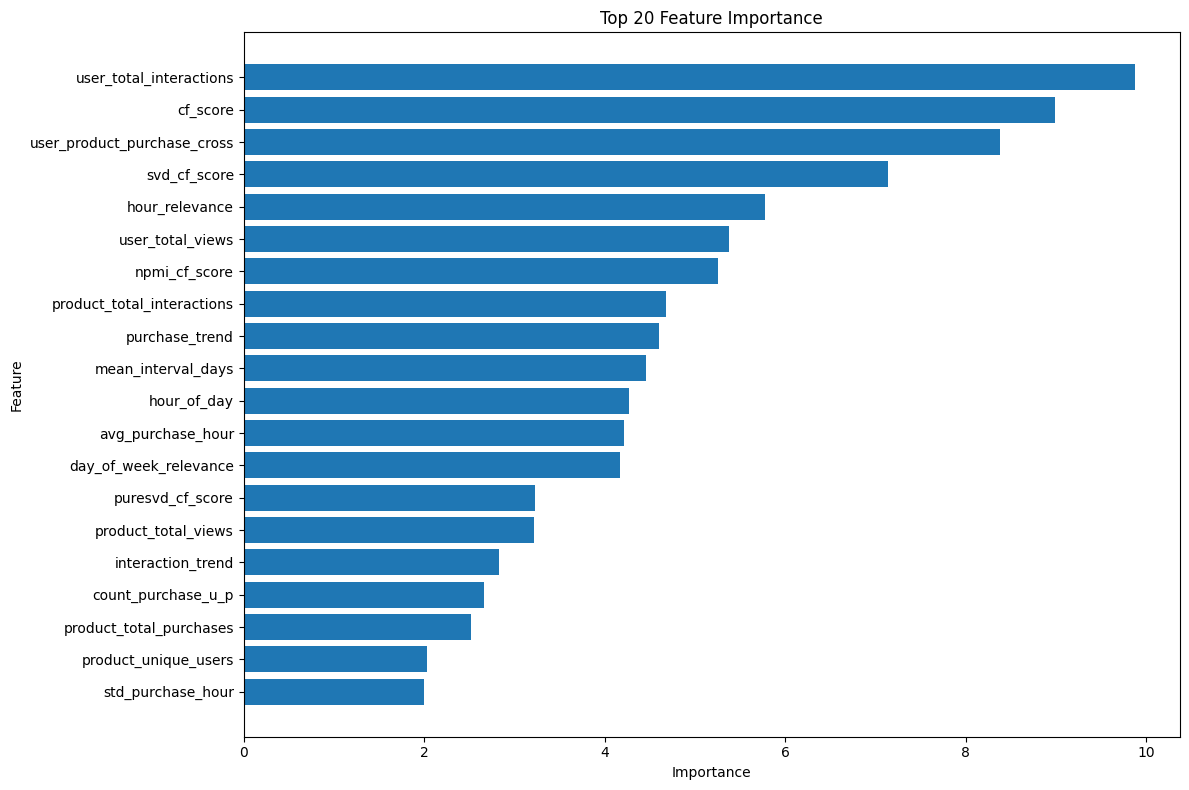

In [6]:
# Print top 10 most important features
print("Top 10 most important features:")
top_features = sorted(
    results['feature_importance'].items(), 
    key=lambda x: x[1], 
    reverse=True
)[:10]

for feature, importance in top_features:
    print(f"{feature}: {importance:.6f}")

vis = Visualizer.plot_feature_importance(results['feature_importance'])


In [7]:
# best_params = results.get('best_params')  # Will be None if using run() without tuning
best_params = {'iterations': 189}
submission = experiment.predict(best_params)

print(f"\nPredictions generated. First 5 rows:")
print(submission.head(10))

print(f"\nExperiment completed: {experiment_name}")

2025-04-14 02:16:24,172 - lavka_recsys.Experiment(recommender_20250414_020031_5af5fe) - INFO - Training final model for prediction
2025-04-14 02:16:26,590 - lavka_recsys.DataLoader - INFO - Final split: history until 2023-12-01 20:23:15
2025-04-14 02:16:26,592 - lavka_recsys.DataLoader - INFO - Final training: 2023-12-01 20:23:15 to 2023-12-31 20:53:44
2025-04-14 02:16:26,592 - lavka_recsys.DataLoader - INFO - Final split data: 13444142 history, 1510275 train rows
2025-04-14 02:16:26,593 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase_user_product, count_purchase_user_store, ctr_product, user_stats, product_stats, store_stats, city_stats, recency_user_product, recency_user_store, time_features, time_window_user_product, product_temporal_patterns, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, svd-cf, puresvd-cf
2025-04-14 02:17:15,813 - lavka_recsys.FeatureFactory - INFO - Joined featur

In [8]:
submission['predict'].describe()

statistic,value
str,f64
"""count""",565231.0
"""null_count""",0.0
"""mean""",0.019958
"""std""",0.021405
"""min""",0.000327
"""25%""",0.009438
"""50%""",0.013448
"""75%""",0.021411
"""max""",0.485127
